In [ ]:
# External libraries import
import matplotlib.pyplot as plt
import numpy as np
import math
# Local libraries import
from AReS import Simulator, Model, Interaction, DoHMeasure, DisturbanceType, SimulatorMode, TciMode

In [2]:
stimuli = {
    1 * 60: (DisturbanceType.INTUBATION, 2 * 60, [10, 10, 20]), 
    5 * 60: (DisturbanceType.INCISION, 2 * 60, [10, 10, 20]),  
    10 * 60: (DisturbanceType.SKIN_MANIPULATION, 10 * 60, [5, 5,10]),
    21 * 60: (DisturbanceType.SUTURE, 5 * 60, [2, 2, 4]) 
}

In [3]:
interaction = Interaction.SURFACE
doh_measure = DoHMeasure.BOTH
t_sim = 30 * 60
t_s = 5
pk_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}
pd_models = {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}

In [4]:
simulator = Simulator.create(SimulatorMode.CONCENTRATION)
limits_TCI = {'cp_limit_prop': 10, 'cp_limit_remi': 10, 'infusion_limit_prop': 2,
              'infusion_limit_remi': 0.5}
modes_TCI = {'prop': TciMode.EFFECT_SITE, 'remi': TciMode.EFFECT_SITE}

t_prop = [2.0] * t_sim
t_remi = [3.6] * t_sim
t_nore = [0.5] * t_sim
t_rocu = [0.0] * t_sim

patient_id = 29
for idx, k in enumerate([patient_id, patient_id, patient_id,patient_id]):
    is_disturbed = (idx % 2 == 0)
    current_stimuli = stimuli if is_disturbed else None

    simulator.init_simulation_from_file(
        id_patient=k,
        t_sim=t_sim,
        t_s=t_s,
        pk_models=pk_models,
        pd_models=pd_models,
        pk_models_TCI=pk_models,
        pd_models_TCI=pd_models,
        modes_TCI= modes_TCI,
        interaction=interaction,
        doh_measure=doh_measure,
        seed_disturbance=42,
        stimuli=current_stimuli,
        limits_TCI=limits_TCI
    )

    simulator.run_complete_simulation(t_prop, t_remi, t_nore, t_rocu)
    simulator.save_simulation()

# Fetch all results after simulations
results = simulator.get_patient_results()

In [5]:
name = {'_CO_all': 'CO', '_WAV_all': 'WAV', '_MAP_all': 'MAP', '_HR_all': 'HR', '_cp_prop_all': 'cp_prop', '_cp_remi_all': 'cp_remi'}
units = {'_CO_all': '[L/min]', '_WAV_all': '', '_MAP_all': '[mmHg]', '_HR_all': '[bpm]', '_cp_prop_all': '[μg/mL]', '_cp_remi_all': '[ng/mL]'}
# Compare disturbed (i) vs undisturbed (i+1) for each pair
for i in range(0, 4, 2):
    print(f"\nPatient {patient_id}")
    for start, value in stimuli.items():
        disturbance_type, duration, params = value
        print(f" Disturbance: {disturbance_type.name}")
        for key in name:
            disturbed = results[key][i][start + duration]
            normal = results[key][i + 1][start + duration]
            diff = disturbed - normal
            print(f"    {name[key]}: {diff:.2f}")


Patient 29
 Disturbance: INTUBATION
    CO: 0.78
    WAV: 9.34
    MAP: 18.69
    HR: 9.34
    cp_prop: 0.00
    cp_remi: 0.00
 Disturbance: INCISION
    CO: 0.50
    WAV: 6.41
    MAP: 12.82
    HR: 6.41
    cp_prop: 0.00
    cp_remi: 0.00
 Disturbance: SKIN_MANIPULATION
    CO: 0.46
    WAV: 6.41
    MAP: 12.82
    HR: 6.41
    cp_prop: 0.00
    cp_remi: 0.00
 Disturbance: SUTURE
    CO: 0.48
    WAV: 6.81
    MAP: 13.62
    HR: 6.81
    cp_prop: 0.00
    cp_remi: 0.00

Patient 29
 Disturbance: INTUBATION
    CO: 0.78
    WAV: 9.34
    MAP: 18.69
    HR: 9.34
    cp_prop: 0.00
    cp_remi: 0.00
 Disturbance: INCISION
    CO: 0.50
    WAV: 6.41
    MAP: 12.82
    HR: 6.41
    cp_prop: 0.00
    cp_remi: 0.00
 Disturbance: SKIN_MANIPULATION
    CO: 0.46
    WAV: 6.41
    MAP: 12.82
    HR: 6.41
    cp_prop: 0.00
    cp_remi: 0.00
 Disturbance: SUTURE
    CO: 0.48
    WAV: 6.81
    MAP: 13.62
    HR: 6.81
    cp_prop: 0.00
    cp_remi: 0.00


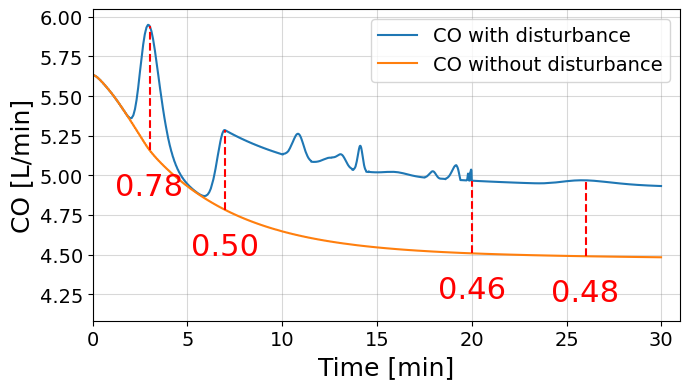

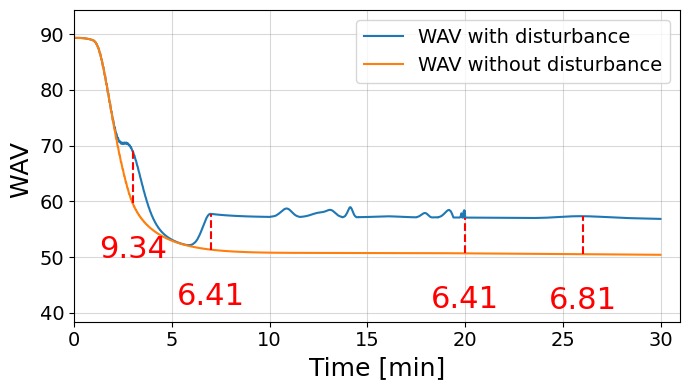

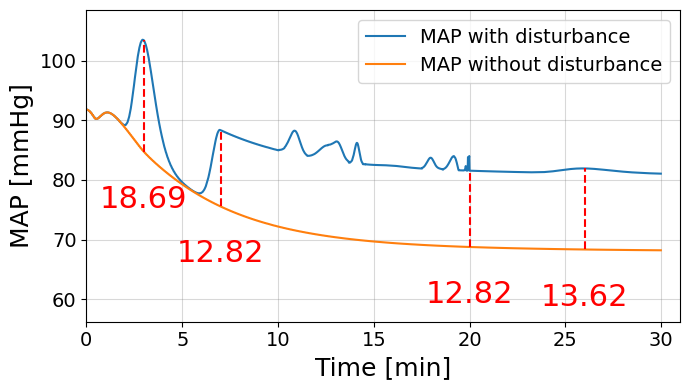

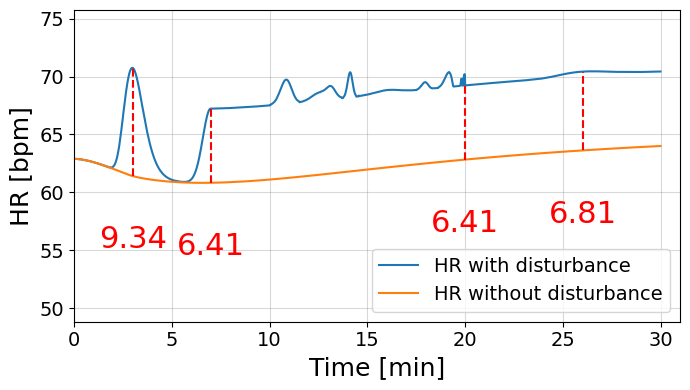

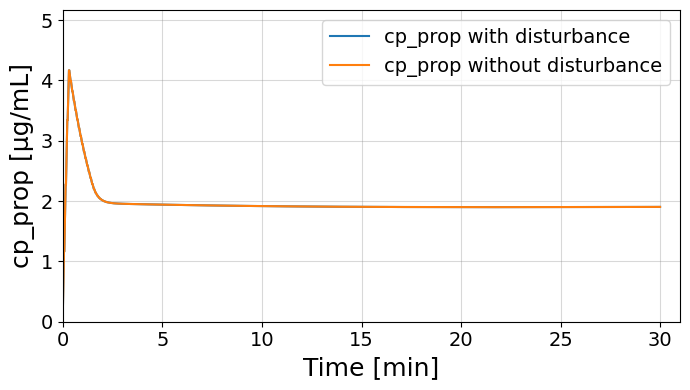

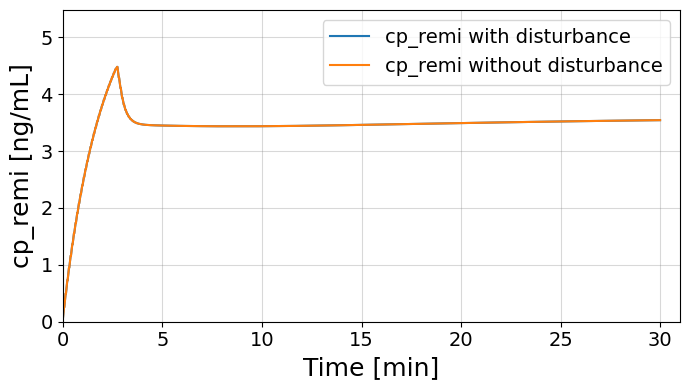

In [7]:
num_samples = len(results['_WAV_all'][0])
t = np.arange(num_samples) / 60
for key in name.keys():
    for i in range(0, 2, 2):
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(t,results[key][i], label=f'{name[key]} with disturbance')
        ax.plot(t,results[key][i+1], label=f'{name[key]} without disturbance')
        ax.set_xlim(0, t[-1]+1)
        if key == '_CO_all':
            ax.set_ylim(min(results[key][i+1]) - 0.4, max(results[key][i]) + 0.1)
            text_offset = 0.1
        elif key in ['_cp_prop_all', '_cp_remi_all']:
            ax.set_ylim(0, max(results[key][i]) + 1)
        else:
            ax.set_ylim(min(results[key][i+1]) - 12, max(results[key][i]) + 5)
            text_offset = 5
        if key in ['_cp_prop_all', '_cp_remi_all']:
            pass
        else:
            for start, value in stimuli.items():
                type, duration, params = value
                x = math.floor((start + duration) / 60)
                y_max = results[key][i][start + duration]
                y_min = results[key][i+1][start + duration]
                ax.vlines(x=x, ymin=y_min, ymax=y_max, color='red', linestyle='--')
                delta_y = (max(results[key][i]) - min(results[key][i+1])) / 8
                ax.text(x, y_min - delta_y - text_offset, f"{(y_max-y_min):.2f}", color='red', fontsize=22, ha='center')
        
        ax.set_xlabel('Time [min]',fontsize=18)
        ax.set_ylabel(f'{name[key]} {units[key]}', fontsize=18)
        ax.legend(fontsize=14)
        plt.grid(axis='both', color='gray', alpha=0.3)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig(f'{name[key]}_with_and_without_disturbance.pdf', format='pdf')
        plt.show()

In [8]:
simulator.reset()
num_patients = 44  
for k_patient_id in range(num_patients):
    current_stimuli = stimuli 

    simulator.init_simulation_from_file(
        id_patient=k_patient_id,
        t_sim=t_sim,
        t_s=t_s,
        pk_models=pk_models,
        pd_models=pd_models,
        pk_models_TCI=pk_models,
        pd_models_TCI=pd_models,
        modes_TCI= modes_TCI,
        interaction=interaction,
        doh_measure=doh_measure,
        seed_disturbance=k_patient_id,
        stimuli=current_stimuli,
        limits_TCI=limits_TCI
    )

    simulator.run_complete_simulation(t_prop, t_remi, t_nore, t_rocu)
    simulator.save_simulation()

# Fetch all results after simulations
results = simulator.get_patient_results()

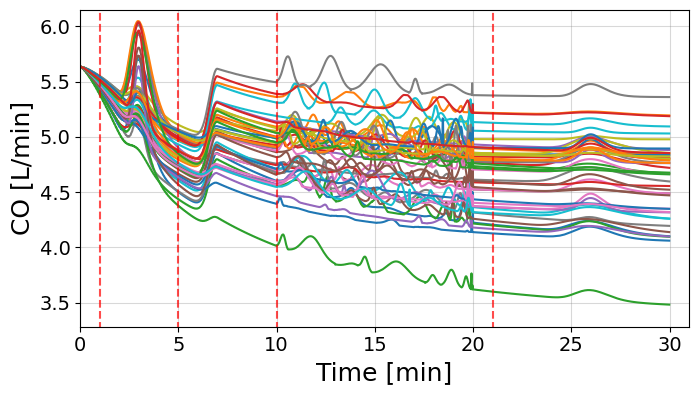

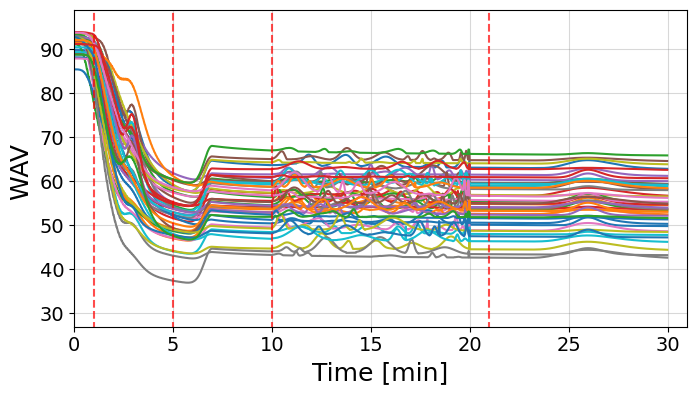

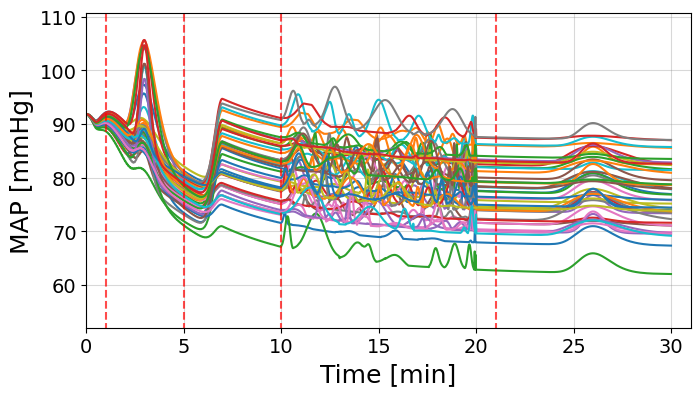

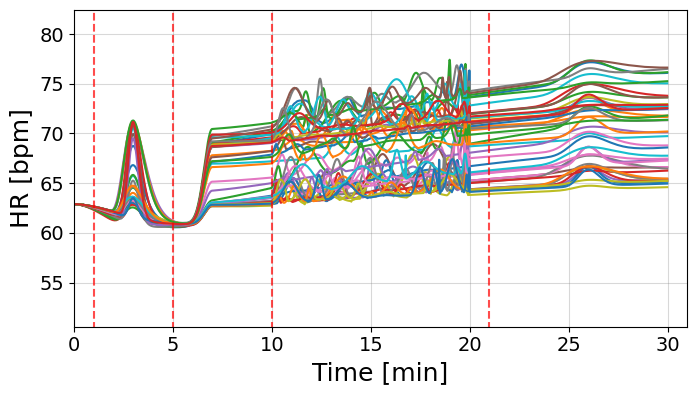

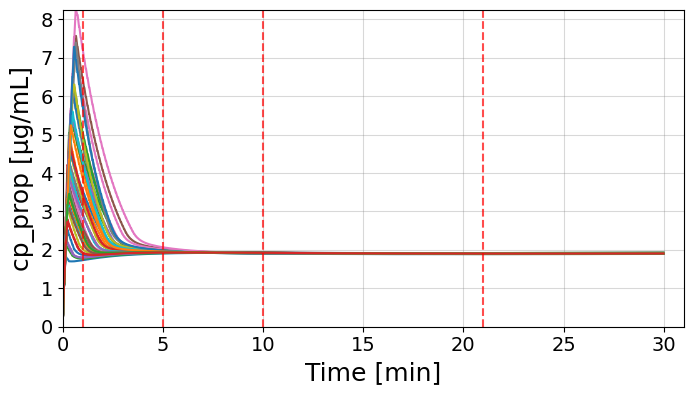

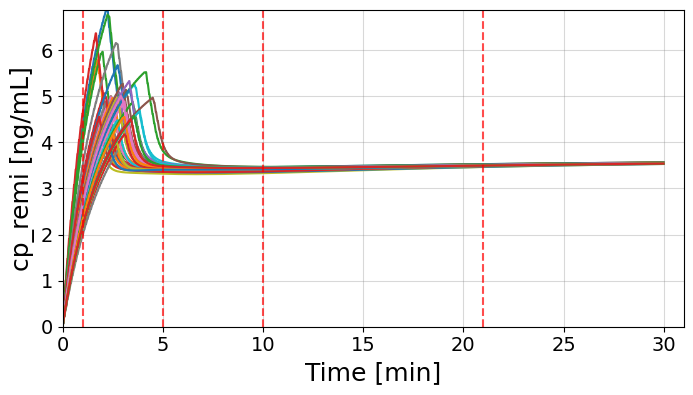

In [9]:
for key in name.keys():
    fig, ax = plt.subplots(figsize=(7, 4))
    y_plot = np.asarray(results[key][:])
    ax.plot(t,y_plot.T)
    ax.set_xlabel('Time [min]', fontsize=18)
    ax.set_ylabel(f'{name[key]} {units[key]}', fontsize=18)
    ax.set_xlim(0, t[-1] + 1)
    if key == '_CO_all':
        ylim_max = np.max(y_plot) + 0.1
        ax.set_ylim(np.min(y_plot) - 0.2, ylim_max)
    elif key in ['_cp_prop_all', '_cp_remi_all']:
        ylim_max = np.max(y_plot)
        ax.set_ylim(0, ylim_max)
    else:
        ylim_max = np.max(y_plot) + 5
        ax.set_ylim(np.min(y_plot) - 10, ylim_max)
    for start in stimuli:
        start = start/60
        ax.vlines(x=start, ymin=0, ymax=ylim_max, color='red', linestyle='--', alpha=0.7)
        
    # ax.legend()
    plt.tight_layout()
    plt.grid(axis='both', color='gray', alpha=0.3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(f'{name[key]}_ext_stimuli.pdf', format='pdf')
    plt.show()